# Player and Team Movement Paths Visualization

This notebook visualizes the movement paths of players and teams during game sessions using synthetic data generated through custom mathematical functions.

We query the `stage_centroids` table to extract 3D centroid positions for teams over time, then plot their trajectories on an XYZ coordinate grid. These centroid paths represent the average location of all players in each team at each timestamp.

> **Note:**  
> The movement patterns may appear unusual or "funny" compared to real-world data. This is because the underlying data is entirely synthetic and created using deterministic math functions for simulation purposes. The paths reflect simplified, idealized movements designed to test analytics pipelines rather than replicate real player behavior.


In [2]:
import duckdb
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches


db_path = Path('../data/synthetic.duckdb').resolve()
conn = duckdb.connect(database=str(db_path), read_only=False)

In [3]:
# Query to sample sessions and players
sample_query = """
WITH session_durations AS (
    SELECT
        session_id,
        MIN(event_datetime) AS session_start,
        MAX(event_datetime) AS session_end,
        datediff('second', MIN(event_datetime), MAX(event_datetime)) AS duration_seconds
    FROM sprint_stage.event_heartbeat
    GROUP BY session_id
),
top_sessions AS (
    SELECT session_id
    FROM session_durations
    ORDER BY duration_seconds DESC
    LIMIT 3
)

SELECT
    eh.session_id,
    eh.player_id,
    eh.event_datetime,
    eh.position_x,
    eh.position_y,
    eh.position_z
FROM sprint_stage.event_heartbeat eh
JOIN top_sessions ts ON eh.session_id = ts.session_id
ORDER BY eh.session_id, eh.player_id, eh.event_datetime

"""

paths = conn.execute(sample_query).df()
paths

,session_id,player_id,event_datetime,position_x,position_y,position_z
0,2ac612a0-ebf1-4d9a-b5e8-978d6bc648fb,0024,2025-10-12 08:32:40,-65.388000,82.098999,-60.536999
1,2ac612a0-ebf1-4d9a-b5e8-978d6bc648fb,0024,2025-10-12 08:33:10,-56.848999,76.889000,-50.483002
2,2ac612a0-ebf1-4d9a-b5e8-978d6bc648fb,0024,2025-10-12 08:33:40,-49.164001,72.199997,-41.435001
3,2ac612a0-ebf1-4d9a-b5e8-978d6bc648fb,0024,2025-10-12 08:34:10,-42.248001,67.980003,-33.291000
4,2ac612a0-ebf1-4d9a-b5e8-978d6bc648fb,0024,2025-10-12 08:34:40,-36.022999,64.181999,-25.962000
...,...,...,...,...,...,...
652,52866e3f-9e73-4d2a-88b6-07e8c176d49d,0731,2025-11-14 04:51:30,-79.337997,30.684000,-46.332001
653,52866e3f-9e73-4d2a-88b6-07e8c176d49d,0731,2025-11-14 04:52:00,-79.336998,30.510000,-46.430000
654,52866e3f-9e73-4d2a-88b6-07e8c176d49d,0731,2025-11-14 04:52:30,-79.336998,30.326000,-46.509998
655,52866e3f-9e73-4d2a-88b6-07e8c176d49d,0731,2025-11-14 04:53:00,-79.336998,30.136000,-46.570999


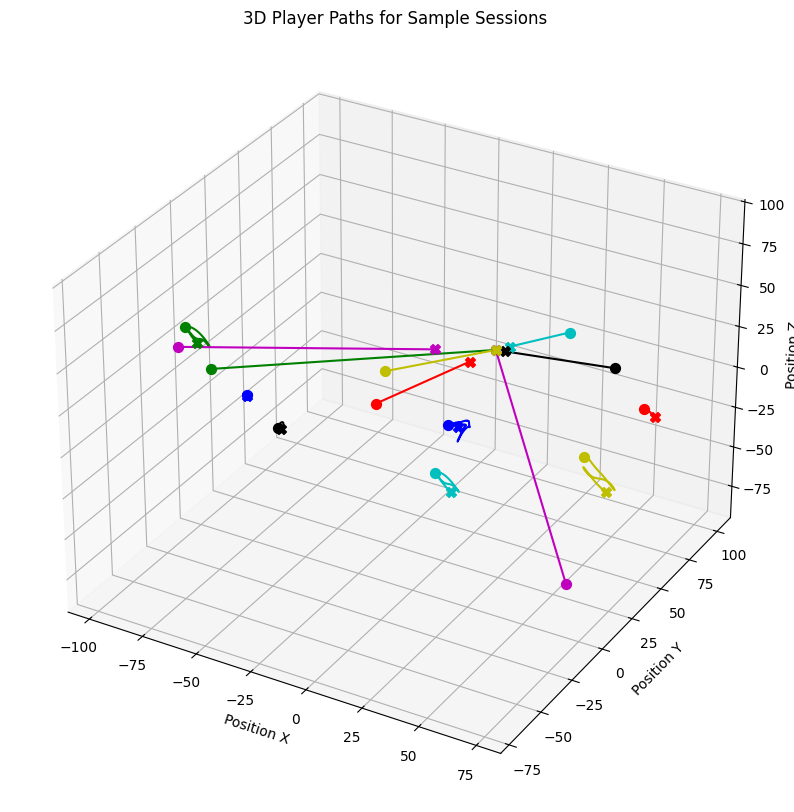

In [4]:
groups = paths.groupby(['session_id', 'player_id'])

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, ((session, player), group) in enumerate(groups):
    color = colors[i % len(colors)]
    ax.plot(group['position_x'], group['position_y'], group['position_z'],
            label=f'Session {session} Player {player}', color=color)
    ax.scatter(group['position_x'].iloc[0], group['position_y'].iloc[0], group['position_z'].iloc[0], 
               marker='o', color=color, s=50)  # Start point
    ax.scatter(group['position_x'].iloc[-1], group['position_y'].iloc[-1], group['position_z'].iloc[-1], 
               marker='X', color=color, s=50)  # End point

ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')
ax.set_title('3D Player Paths for Sample Sessions')
# ax.legend()
plt.show()

In [5]:
sample_centroids_query = """
SELECT
    session_id,
    team_id,
    event_datetime,
    centroid_x,
    centroid_y,
    centroid_z
FROM sprint_stage.stage_centroids
WHERE session_id IN (
    SELECT DISTINCT session_id FROM sprint_stage.stage_centroids
    LIMIT 3
)
ORDER BY session_id, team_id, event_datetime
"""

df_centroids = conn.execute(sample_centroids_query).df()
df_centroids.head()

,session_id,team_id,event_datetime,centroid_x,centroid_y,centroid_z
0,015a4f60-e361-4e39-a5ed-268fd8cca27c,3587bdd2-e600-4020-977c-c2d96686f997,2025-12-09 08:02:28,-92.738998,40.006001,87.749001
1,015a4f60-e361-4e39-a5ed-268fd8cca27c,3587bdd2-e600-4020-977c-c2d96686f997,2025-12-09 08:02:58,-92.111000,40.048000,88.232002
2,015a4f60-e361-4e39-a5ed-268fd8cca27c,3587bdd2-e600-4020-977c-c2d96686f997,2025-12-09 08:03:28,-90.942001,39.976002,89.172997
3,015a4f60-e361-4e39-a5ed-268fd8cca27c,3587bdd2-e600-4020-977c-c2d96686f997,2025-12-09 08:03:58,-89.427002,39.629002,90.469002
4,015a4f60-e361-4e39-a5ed-268fd8cca27c,3587bdd2-e600-4020-977c-c2d96686f997,2025-12-09 08:04:28,-87.832001,38.932999,91.931999


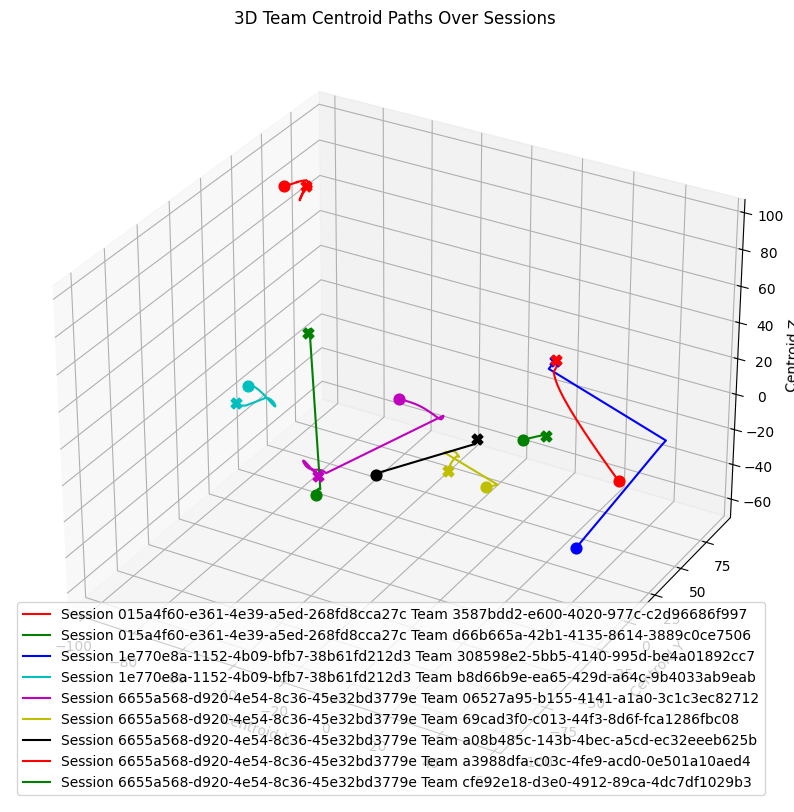

In [6]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

groups = df_centroids.groupby(['session_id', 'team_id'])
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for i, ((session, team), group) in enumerate(groups):
    color = colors[i % len(colors)]
    ax.plot(group['centroid_x'], group['centroid_y'], group['centroid_z'],
            label=f'Session {session} Team {team}', color=color)
    ax.scatter(group['centroid_x'].iloc[0], group['centroid_y'].iloc[0], group['centroid_z'].iloc[0],
               marker='o', color=color, s=60)  # start point
    ax.scatter(group['centroid_x'].iloc[-1], group['centroid_y'].iloc[-1], group['centroid_z'].iloc[-1],
               marker='X', color=color, s=60)  # end point

ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_zlabel('Centroid Z')
ax.set_title('3D Team Centroid Paths Over Sessions')
ax.legend()
plt.show()

In [7]:
rfm_query = """
WITH player_transactions AS (
    SELECT
        playerId,
        MAX(eventDateTime) AS last_purchase,
        COUNT(*) AS frequency,
        SUM(purchasePrice) AS monetary
    FROM sprint_raw.event_transaction
    GROUP BY playerId
),

-- Calculate recency in days relative to a fixed analysis date (e.g., max transaction date or today)
analysis_date AS (
    SELECT MAX(eventDateTime) AS max_date FROM sprint_raw.event_transaction
)

SELECT
    pt.playerId,
    CAST((julian(ad.max_date::timestamp) - julian(pt.last_purchase::timestamp)) AS INTEGER) AS recency_days,
    pt.frequency,
    pt.monetary
FROM player_transactions pt, analysis_date ad
ORDER BY pt.playerId
"""

df_rfm = conn.execute(rfm_query).df()
df_rfm

,playerId,recency_days,frequency,monetary
0,0000,0,96,1430.14
1,0001,7,190,2754.80
2,0002,6,80,939.83
3,0003,0,122,1641.78
4,0004,2,182,2493.09
...,...,...,...,...
995,0995,12,97,1214.66
996,0996,5,167,2236.01
997,0997,3,101,1349.41
998,0998,0,139,1652.70


In [8]:
def rfm_segment(value, quantiles):
    if value <= quantiles[0.33]:
        return 'Low'
    elif value <= quantiles[0.66]:
        return 'Medium'
    else:
        return 'High'

# Compute quantiles for each R, F, M
recency_q = df_rfm['recency_days'].quantile([0.33, 0.66]).to_dict()
frequency_q = df_rfm['frequency'].quantile([0.33, 0.66]).to_dict()
monetary_q = df_rfm['monetary'].quantile([0.33, 0.66]).to_dict()

# Apply segmentation - note for Recency, lower is better so invert logic
df_rfm['R_segment'] = df_rfm['recency_days'].apply(lambda x: 'High' if x <= recency_q[0.33] else ('Medium' if x <= recency_q[0.66] else 'Low'))
df_rfm['F_segment'] = df_rfm['frequency'].apply(lambda x: rfm_segment(x, frequency_q))
df_rfm['M_segment'] = df_rfm['monetary'].apply(lambda x: rfm_segment(x, monetary_q))

# Combine segments for a simple color scheme — e.g., High in all three = red, otherwise blue
def combined_segment_color(row):
    if row['R_segment'] == 'High' and row['F_segment'] == 'High' and row['M_segment'] == 'High':
        return 'red'
    elif row['R_segment'] == 'Low' and row['F_segment'] == 'Low' and row['M_segment'] == 'Low':
        return 'gray'
    else:
        return 'blue'

df_rfm['color'] = df_rfm.apply(combined_segment_color, axis=1)


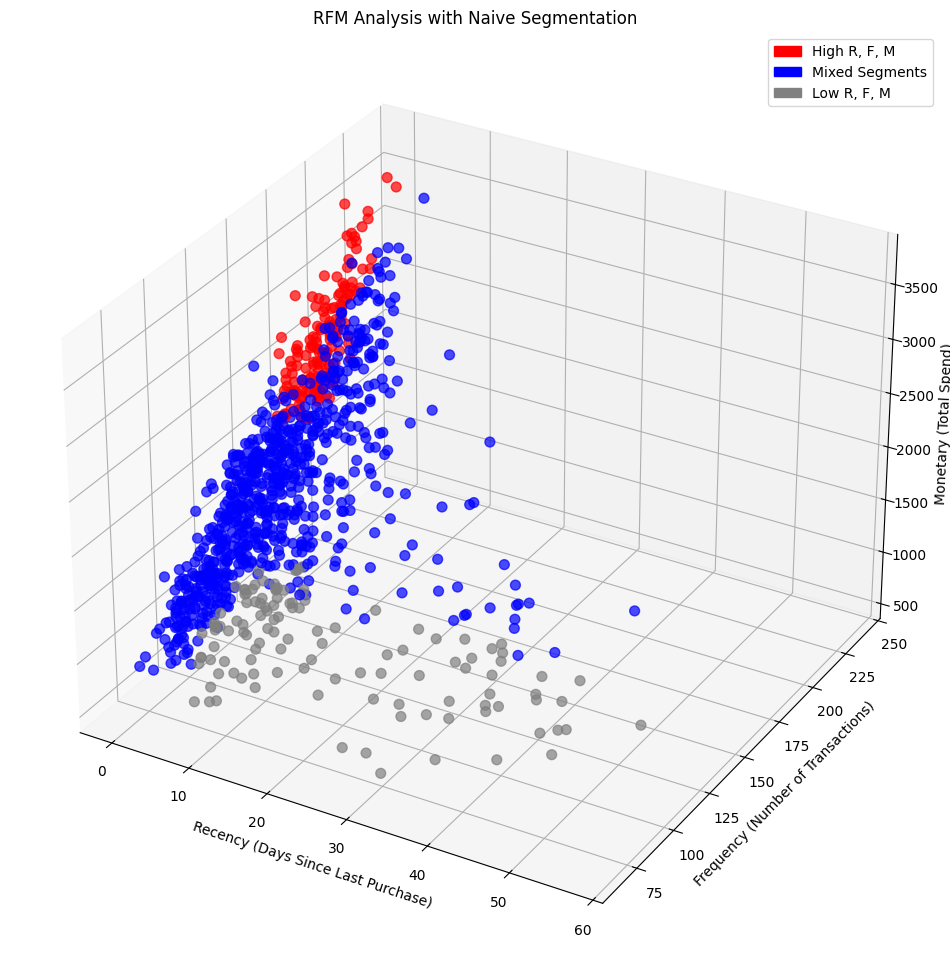

In [9]:
fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(111, projection='3d')

colors = df_rfm['color']

scatter = ax.scatter(df_rfm['recency_days'], df_rfm['frequency'], df_rfm['monetary'],
                     c=colors, alpha=0.7, s=50)

ax.set_xlabel('Recency (Days Since Last Purchase)')
ax.set_ylabel('Frequency (Number of Transactions)')
ax.set_zlabel('Monetary (Total Spend)')
ax.set_title('RFM Analysis with Naive Segmentation')

# Create a simple legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='High R, F, M')
blue_patch = mpatches.Patch(color='blue', label='Mixed Segments')
gray_patch = mpatches.Patch(color='gray', label='Low R, F, M')
plt.legend(handles=[red_patch, blue_patch, gray_patch])

plt.show()


## RFM Segmentation Commentary

This 3D RFM plot helps us understand player transaction behavior by visualizing:

- **Recency:** How recently a player made their last purchase (lower is better).
- **Frequency:** How often a player makes purchases.
- **Monetary:** Total spend by the player.

By segmenting players based on these dimensions, we can identify key groups such as:

- **Loyal Players:** Recent, frequent purchasers with high monetary value.
- **At-Risk Players:** Players with longer recency but historically high spend.
- **New Players:** Recent purchasers with low frequency.
- **Low-Value Players:** Rare or low-spending purchasers.

Segmentation techniques like k-means clustering or simple threshold binning on these RFM scores can help target marketing, promotions, and retention efforts more effectively.

In our example, we do a simple naive segmentation based on quantiles.
